# Causal Inference

In this notebook, we will use Python package CausalML to estimate Conditional Average Treatment Effect (CATE) for some variables in our data

"Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form."

In his notebook ['INSY_695_Model_Development_Selection_CrossValidation.ipynb'](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/DataScientist/INSY_695_Model_Development_Selection_CrossValidation.ipynb), my teammate Raman Vakil found that an extra tree regressor was the most accurate model for estimating the cost of aquiring a customer, so we will move forward with an extra tree model as our base algorithm in our Meta-Learner algorithm.

### [Business Use Cases to Keep in mind](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/tree/BusinessAnalyst)
**Profit:** the idea here is to look at the ratio (Revenue-Cost)/Revenue, it would be interesting to understand what factors increase or decrease this ratio. If some types of stores are more profitable than others, that also mean the stores in question can reinvest more in their business in the opposite of other that may lose money.


**Loyalty:** We have a loyalty feature based on different categories (normal, bronze, silver, or gold). The idea is to “measure loyalty”.



In [36]:
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from causalml.inference.meta import BaseSRegressor
import numpy as np
import matplotlib.pyplot as plt


/Users/bennettfahey/opt/anaconda3/envs/quant/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Input data in this notebook is the output of my teammate Chongho Pyo's [preprocessing notebook: ](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/main/Preprocessing%20(v0.0).ipynb) Data will be modified however with label feature encoding, as opposed to one-hot encoding, this will allow for easier interpretation of treatment variables.

In [9]:
df = pd.read_csv("/Users/bennettfahey/Desktop/Enterprise 1/Group Project/causal_inf_input.csv")

### Feature engineering as it relates to our business use cases

In [20]:
df['profit_margin'] = (df['store_sales(in millions)'] - df['store_cost(in millions)']) / df['store_sales(in millions)']
corr_matrix = df.corr()
corr_matrix["profit_margin"].sort_values(ascending=False)

/var/folders/c1/mjq2xvq1539_5t_dhspx7m8m0000gn/T/ipykernel_29932/3412314252.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


profit_margin                 1.000000
store_sales(in millions)      0.012378
recyclable_package            0.008357
SRP                           0.008024
net_weight                    0.007237
unit_sales(in millions)       0.007177
gross_weight                  0.006151
frozen_sqft                   0.005425
meat_sqft                     0.005423
florist                       0.005107
store_sqft                    0.004989
salad_bar                     0.004794
prepared_food                 0.004794
video_store                   0.004775
low_fat                       0.004598
total_children                0.004061
grocery_sqft                  0.003558
units_per_case                0.003124
avg_cars_at home(approx).1    0.002302
avg_cars_at home(approx)      0.002302
store_cost(in millions)      -0.001013
coffee_bar                   -0.001309
num_children_at_home         -0.004400
cost                         -0.005076
Name: profit_margin, dtype: float64

Observed here sales (revenue) is positively correlated with profit margin and cost is negatively correlated.

In [32]:
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
#df['media_type'] = label_encoder.fit_transform(df['media_type'].tolist())

for column in df.columns:
    if df[column].dtype == 'object': 
        df[column] = label_encoder.fit_transform(df[column].tolist()) 
        


# UC1: Effect of Gender on Cost of aquisition

In [45]:
#Gender on cost
#Something on ratio
#loyalty

df2 = df.copy()
y = df2["cost"]
W = df2[["gender"]]
W = np.array(W)
X = df2.drop(columns = ["cost", "gender"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [40]:
features = X.columns
features

Index(['store_sales(in millions)', 'store_cost(in millions)',
       'unit_sales(in millions)', 'total_children', 'avg_cars_at home(approx)',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'SRP',
       'gross_weight', 'net_weight', 'units_per_case', 'store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'food_category',
       'food_department', 'food_family', 'promotion_name', 'sales_country',
       'marital_status', 'education', 'member_card', 'occupation',
       'houseowner', 'avg. yearly_income', 'brand_name', 'store_type',
       'store_city', 'store_state', 'media_type', 'recyclable_package',
       'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'profit_margin'],
      dtype='object')

In [41]:
base_algo = ExtraTreesRegressor()

In [42]:
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.181240
 media_type                    0.141853
 total_children                0.073060
 education                     0.056733
 occupation                    0.056200
 avg. yearly_income            0.054282
 houseowner                    0.052228
 avg_cars_at home(approx)      0.046142
 avg_cars_at home(approx).1    0.044026
 member_card                   0.038634
 marital_status                0.038493
 num_children_at_home          0.035588
 meat_sqft                     0.015864
 grocery_sqft                  0.015821
 unit_sales(in millions)       0.013320
 store_sqft                    0.012427
 frozen_sqft                   0.012425
 store_city                    0.011664
 store_state                   0.011259
 store_type                    0.008997
 low_fat                       0.007406
 food_department               0.007356
 florist                       0.005646
 net_weight                    0.005138
 profit_margin           

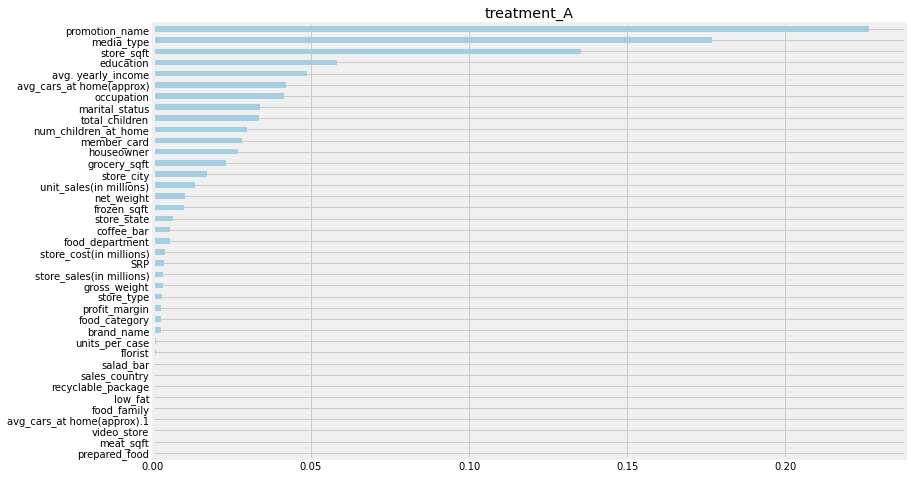

In [43]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

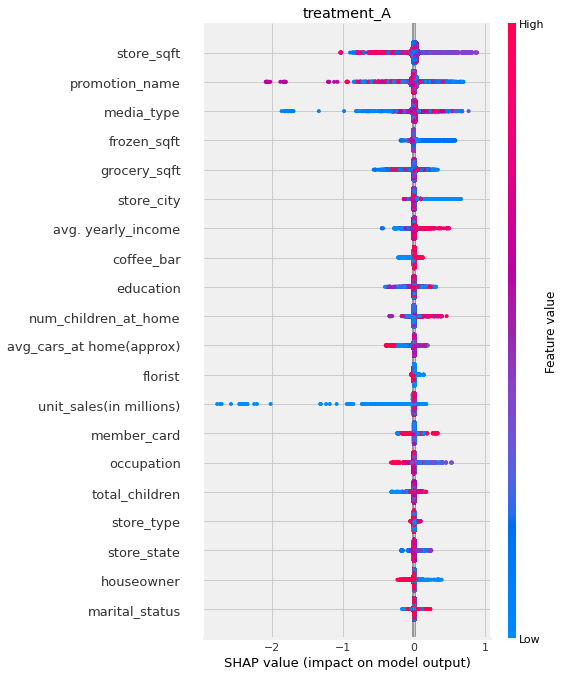

In [44]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)

# UC2: Member card status on profit margin

In [46]:
df2 = df.copy()
y = df2["profit_margin"]
W = df2[["member_card"]]
W = np.array(W)
X = df2.drop(columns = ["profit_margin", "member_card"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [47]:
base_algo = ExtraTreesRegressor()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

invalid value encountered in divide
invalid value encountered in divide


{'treatment_A': net_weight                    0.062179
 store_sales(in millions)      0.049991
 avg. yearly_income            0.049263
 units_per_case                0.047256
 gross_weight                  0.046527
 SRP                           0.045945
 store_cost(in millions)       0.045808
 food_category                 0.043266
 marital_status                0.041618
 profit_margin                 0.036395
 brand_name                    0.034348
 media_type                    0.032281
 food_department               0.032278
 num_children_at_home          0.030758
 promotion_name                0.029159
 store_city                    0.022557
 avg_cars_at home(approx).1    0.022455
 meat_sqft                     0.022357
 low_fat                       0.021578
 frozen_sqft                   0.020277
 member_card                   0.019903
 avg_cars_at home(approx)      0.019891
 unit_sales(in millions)       0.019710
 total_children                0.019274
 occupation              

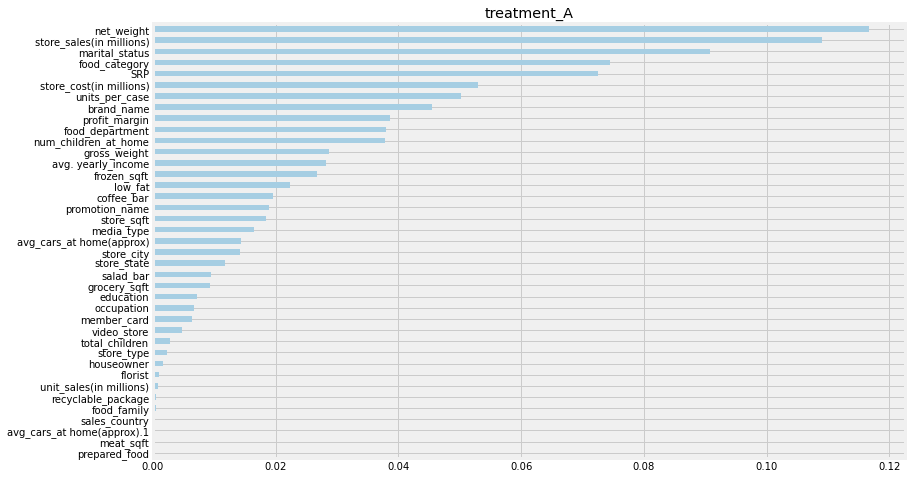

In [48]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

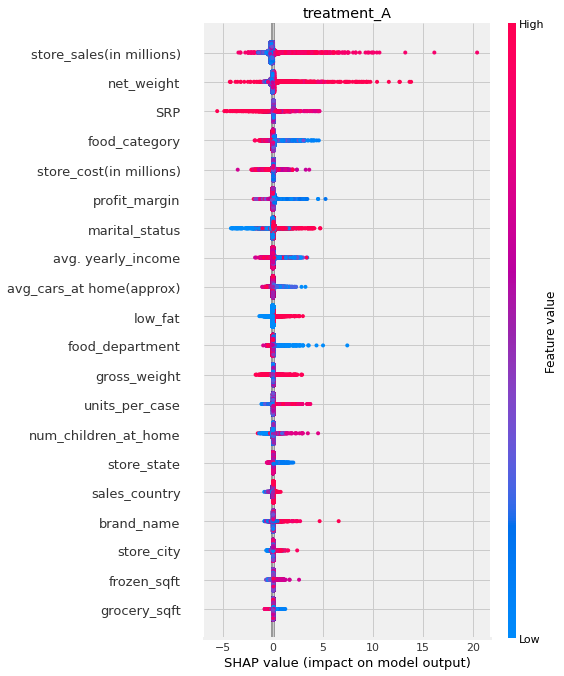

In [49]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)

# UC3: ?